## Logic Based FizzBuzz Function [Software 1.0]

In [134]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import np_utils
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt

In [135]:
def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

In [136]:
# This function takes dataset containing pairs and 
# returns a dataframe of n*21 dimention containing their image specifications 
# It performs feature concatination, i.e. It takes two sets of 9 features for each image
# and concats them into 18 features

def merge_data_set_feature_concatenation(image_specs, pair_set):
    df3 = pd.merge(pair_set, image_specs ,left_on = "img_id_A", right_on = "img_id",how="inner")
    df4 = pd.merge(df3, image_specs ,left_on = 'img_id_B', right_on = 'img_id',how="inner")
    
    targets = df4['target']

    _RawTarget = targets.values
    datasetStriped = df4.drop(['img_id_A', 'img_id_B', 'target','img_id_x', 'img_id_y'], axis=1)
    
    uniques = datasetStriped.apply(lambda x: x.nunique())
    datasetStriped = datasetStriped.drop(uniques[uniques==1].index, axis=1)
    
    _RawData = datasetStriped.values
    
    return _RawTarget, _RawData

# This function takes dataset containing pairs and 
# returns a dataframe of n*12 dimention containing their image specifications 
# It performs feature subtraction, i.e. It takes two sets of 9 features for each image
# and subtracts them and return 9 features

def merge_data_set_feature_subtraction(image_specs, pair_set):
    targets = pair_set['target']
    
    df3 = pd.merge(pair_set, image_specs ,left_on = "img_id_A", right_on = "img_id",how="inner")
    df3 = df3.drop(['img_id_A', 'img_id_B', 'target','img_id'], axis=1)
    

    df4 = pd.merge(pair_set, image_specs ,left_on = 'img_id_B', right_on = 'img_id',how="inner")
    df4 = df4.drop(['img_id_A', 'img_id_B', 'target','img_id'], axis=1)
    
    df5 = df3.sub(df4)
    df5 = df5.abs()
    
    uniques = df5.apply(lambda x: x.nunique())
    df5 = df5.drop(uniques[uniques==1].index, axis=1)
    
    temp_np = df5.values
    

    _RawTarget = targets.values
    _RawData = temp_np
    
    return _RawTarget, _RawData

In [137]:
def generate_training_validation_testing_ds(RawTarget, RawData):
    _TrainingTarget = GenerateTrainingTarget(RawTarget,TrainingPercent)
    _TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
    print("Training Target: "+ str(_TrainingTarget.shape))
    print("Training Data: "+ str(_TrainingData.shape))

    _ValDataAct = GenerateValTargetVector(RawTarget,ValidationPercent, (len(_TrainingTarget)))
    _ValData    = GenerateValData(RawData,ValidationPercent, (len(_TrainingTarget)))
    print("Validation Target: "+ str(_ValDataAct.shape))
    print("Validation Data: "+ str(_ValData.shape))
    
    return _TrainingTarget, _TrainingData, _ValDataAct, _ValData

## Model Definition

In [173]:
def get_model(input_size, drop_out, dl_1_nodes, dl_2_nodes, dl_3_nodes):

    
    model = Sequential()
    
#     model.add(Dense(dl_1_nodes, input_dim=input_size))
#     model.add(Activation('relu'))
  
#     model.add(Dropout(drop_out))
    
#     model.add(Dense(dl_2_nodes))
#     model.add(Activation('relu'))

        
#     model.add(Dropout(drop_out))
    
#     model.add(Dense(dl_3_nodes))
#     model.add(Activation('sigmoid'))

    model.add(Dense(dl_1_nodes, input_dim=input_size, kernel_initializer='normal', activation='relu'))
    model.add(Dense(dl_2_nodes, kernel_initializer='normal', activation='relu'))
    model.add(Dense(dl_3_nodes, kernel_initializer='normal', activation='sigmoid'))
    
    model.summary()
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# <font color='blue'>Creating Training and Testing Datafiles</font>

In [174]:
image_specs_df = pd.read_csv("HumanObserved-Dataset/HumanObserved-Features-Data/HumanObserved-Features-Data.csv", index_col=0)

same_pair_df = pd.read_csv("HumanObserved-Dataset/HumanObserved-Features-Data/same_pairs.csv")

diff_pair_df = pd.read_csv("HumanObserved-Dataset/HumanObserved-Features-Data/diffn_pairs.csv")


# create a dataframe by taking a subset from samples of different writers
# Since unmatched dataset is huge we are randomly creating a sample with same data size (791 rows)
# because if the amount of unmatched data overwhelms the matched data, the model may overfit

diff_pair_df_sample = diff_pair_df.sample(n=same_pair_df.shape[0], replace=True)

#Merging same and different writer's data set into one. (1582 rows)
dataset_pairs = pd.concat([diff_pair_df_sample,same_pair_df]).sample(frac=1).reset_index(drop=True)

In [175]:
# Now we are merging the image specifications with the dataset, we will use this dataset to train
# test or validate data.

RawTarget, RawData = merge_data_set_feature_concatenation(image_specs_df, dataset_pairs)
print("=========================")
print("== Human Observed Data ==")
print("==== Concatenation ======")
print("=========================")
print("RawData : " + str(RawData.shape))
print("RawTarget : " + str(RawTarget.shape))




== Human Observed Data ==
==== Concatenation ======
RawData : (1582, 18)
RawTarget : (1582,)


# <font color='blue'>Creating Model</font>

In [182]:
model = get_model(RawData.shape[1], 0.2, 18, 9, 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 18)                342       
_________________________________________________________________
dense_65 (Dense)             (None, 9)                 171       
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 10        
Total params: 523
Trainable params: 523
Non-trainable params: 0
_________________________________________________________________


# <font color = blue>Run Model</font>

In [183]:
validation_data_split = 0.2

num_epochs = 10000  
model_batch_size = 128

tb_batch_size = 32

early_patience = 300

tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)

earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')

# TargetVector = np_utils.to_categorical(np.array(RawTarget),2)

# model fit trains the data according to the parameters given to it.
history = model.fit(RawData
                    , RawTarget
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )

Train on 1265 samples, validate on 317 samples
Epoch 1/10000
1265/1265 [==============================] - 1s 475us/step - loss: 0.6935 - acc: 0.4806 - val_loss: 0.6921 - val_acc: 0.5773
Epoch 2/10000
1265/1265 [==============================] - 0s 39us/step - loss: 0.6932 - acc: 0.4949 - val_loss: 0.6932 - val_acc: 0.5016
Epoch 3/10000
1265/1265 [==============================] - 0s 44us/step - loss: 0.6930 - acc: 0.5320 - val_loss: 0.6937 - val_acc: 0.4196
Epoch 4/10000
1265/1265 [==============================] - 0s 45us/step - loss: 0.6929 - acc: 0.5194 - val_loss: 0.6945 - val_acc: 0.4227
Epoch 5/10000
1265/1265 [==============================] - 0s 44us/step - loss: 0.6927 - acc: 0.5194 - val_loss: 0.6949 - val_acc: 0.4227
Epoch 6/10000
1265/1265 [==============================] - 0s 45us/step - loss: 0.6927 - acc: 0.5194 - val_loss: 0.6956 - val_acc: 0.4227
Epoch 7/10000
1265/1265 [==============================] - 0s 51us/step - loss: 0.6925 - acc: 0.5194 - val_loss: 0.6957 - va

1265/1265 [==============================] - 0s 34us/step - loss: 0.6555 - acc: 0.6032 - val_loss: 0.7206 - val_acc: 0.5110
Epoch 60/10000
1265/1265 [==============================] - 0s 36us/step - loss: 0.6564 - acc: 0.6134 - val_loss: 0.7137 - val_acc: 0.5331
Epoch 61/10000
1265/1265 [==============================] - 0s 56us/step - loss: 0.6552 - acc: 0.6024 - val_loss: 0.7224 - val_acc: 0.5300
Epoch 62/10000
1265/1265 [==============================] - 0s 63us/step - loss: 0.6550 - acc: 0.6063 - val_loss: 0.7181 - val_acc: 0.5300
Epoch 63/10000
1265/1265 [==============================] - 0s 48us/step - loss: 0.6530 - acc: 0.6221 - val_loss: 0.7269 - val_acc: 0.5174
Epoch 64/10000
1265/1265 [==============================] - 0s 45us/step - loss: 0.6540 - acc: 0.6063 - val_loss: 0.7172 - val_acc: 0.5363
Epoch 65/10000
1265/1265 [==============================] - 0s 42us/step - loss: 0.6515 - acc: 0.6182 - val_loss: 0.7256 - val_acc: 0.5268
Epoch 66/10000
1265/1265 [================

Epoch 118/10000
1265/1265 [==============================] - 0s 40us/step - loss: 0.6251 - acc: 0.6435 - val_loss: 0.7638 - val_acc: 0.5047
Epoch 119/10000
1265/1265 [==============================] - 0s 39us/step - loss: 0.6246 - acc: 0.6466 - val_loss: 0.7584 - val_acc: 0.5268
Epoch 120/10000
1265/1265 [==============================] - 0s 35us/step - loss: 0.6224 - acc: 0.6451 - val_loss: 0.7621 - val_acc: 0.5174
Epoch 121/10000
1265/1265 [==============================] - 0s 40us/step - loss: 0.6225 - acc: 0.6466 - val_loss: 0.7646 - val_acc: 0.5205
Epoch 122/10000
1265/1265 [==============================] - 0s 35us/step - loss: 0.6231 - acc: 0.6474 - val_loss: 0.7546 - val_acc: 0.5363
Epoch 123/10000
1265/1265 [==============================] - 0s 40us/step - loss: 0.6259 - acc: 0.6427 - val_loss: 0.7683 - val_acc: 0.5047
Epoch 124/10000
1265/1265 [==============================] - 0s 39us/step - loss: 0.6266 - acc: 0.6332 - val_loss: 0.7736 - val_acc: 0.4984
Epoch 125/10000
1265

1265/1265 [==============================] - 0s 40us/step - loss: 0.6072 - acc: 0.6640 - val_loss: 0.8150 - val_acc: 0.5016
Epoch 177/10000
1265/1265 [==============================] - 0s 44us/step - loss: 0.6120 - acc: 0.6601 - val_loss: 0.7796 - val_acc: 0.5300
Epoch 178/10000
1265/1265 [==============================] - 0s 39us/step - loss: 0.6074 - acc: 0.6648 - val_loss: 0.7831 - val_acc: 0.5237
Epoch 179/10000
1265/1265 [==============================] - 0s 42us/step - loss: 0.6018 - acc: 0.6719 - val_loss: 0.7883 - val_acc: 0.5110
Epoch 180/10000
1265/1265 [==============================] - 0s 45us/step - loss: 0.6002 - acc: 0.6767 - val_loss: 0.7825 - val_acc: 0.5331
Epoch 181/10000
1265/1265 [==============================] - 0s 44us/step - loss: 0.6017 - acc: 0.6672 - val_loss: 0.7928 - val_acc: 0.5110
Epoch 182/10000
1265/1265 [==============================] - 0s 44us/step - loss: 0.6011 - acc: 0.6672 - val_loss: 0.7814 - val_acc: 0.5363
Epoch 183/10000
1265/1265 [=========

1265/1265 [==============================] - 0s 40us/step - loss: 0.5915 - acc: 0.6680 - val_loss: 0.7899 - val_acc: 0.5237
Epoch 235/10000
1265/1265 [==============================] - 0s 37us/step - loss: 0.5883 - acc: 0.6767 - val_loss: 0.8130 - val_acc: 0.5205
Epoch 236/10000
1265/1265 [==============================] - 0s 39us/step - loss: 0.5872 - acc: 0.6909 - val_loss: 0.8128 - val_acc: 0.5205
Epoch 237/10000
1265/1265 [==============================] - 0s 35us/step - loss: 0.5858 - acc: 0.6830 - val_loss: 0.7987 - val_acc: 0.5268
Epoch 238/10000
1265/1265 [==============================] - 0s 34us/step - loss: 0.5873 - acc: 0.6885 - val_loss: 0.8076 - val_acc: 0.5174
Epoch 239/10000
1265/1265 [==============================] - 0s 33us/step - loss: 0.5878 - acc: 0.6806 - val_loss: 0.8066 - val_acc: 0.5174
Epoch 240/10000
1265/1265 [==============================] - 0s 37us/step - loss: 0.5855 - acc: 0.6806 - val_loss: 0.8012 - val_acc: 0.5268
Epoch 241/10000
1265/1265 [=========

1265/1265 [==============================] - 0s 53us/step - loss: 0.5764 - acc: 0.6996 - val_loss: 0.8340 - val_acc: 0.5237
Epoch 293/10000
1265/1265 [==============================] - 0s 47us/step - loss: 0.5742 - acc: 0.7020 - val_loss: 0.8293 - val_acc: 0.5205
Epoch 294/10000
1265/1265 [==============================] - 0s 43us/step - loss: 0.5725 - acc: 0.6964 - val_loss: 0.8320 - val_acc: 0.5205
Epoch 295/10000
1265/1265 [==============================] - 0s 43us/step - loss: 0.5731 - acc: 0.6988 - val_loss: 0.8358 - val_acc: 0.5079
Epoch 296/10000
1265/1265 [==============================] - 0s 40us/step - loss: 0.5723 - acc: 0.7004 - val_loss: 0.8264 - val_acc: 0.5142
Epoch 297/10000
1265/1265 [==============================] - 0s 42us/step - loss: 0.5725 - acc: 0.6996 - val_loss: 0.8349 - val_acc: 0.5205
Epoch 298/10000
1265/1265 [==============================] - 0s 41us/step - loss: 0.5724 - acc: 0.6980 - val_loss: 0.8457 - val_acc: 0.5268
Epoch 299/10000
1265/1265 [=========

# <font color = blue>Training and Validation Graphs</font>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a3b906320>,
      dtype=object)

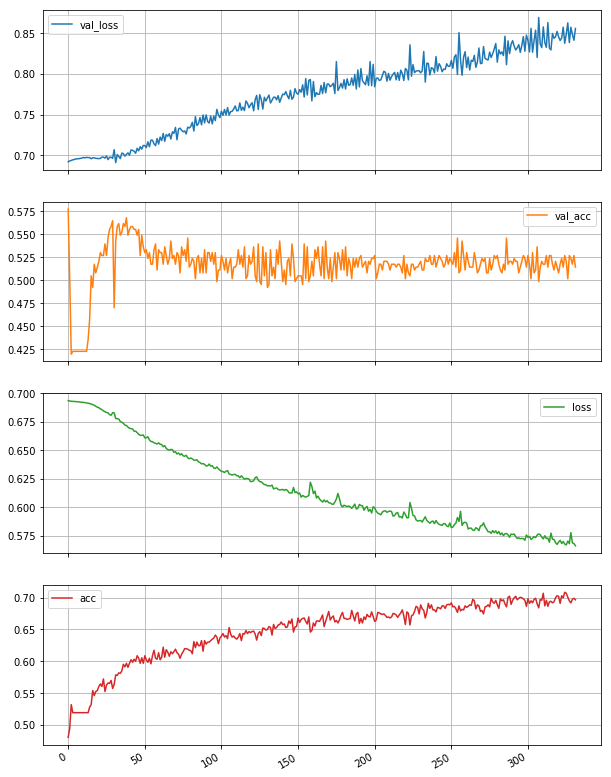

In [184]:
%matplotlib inline

# The history attribute from history object is a record of training loss values and metrics values at 
# successive epochs, as well as validation loss values and validation metrics values. It can be used to plot graphs
# which let us understand how good the training was performed over the epochs.

df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

# <font color = blue>Testing Accuracy [Software 2.0]</font>

In [131]:
def decodeLabel(encodedLabel):
    if encodedLabel == 0:
        return "Other"
    elif encodedLabel == 1:
        return "Fizz"
    elif encodedLabel == 2:
        return "Buzz"
    elif encodedLabel == 3:
        return "FizzBuzz"

In [132]:
# wrong   = 0
# right   = 0

# testData = pd.read_csv('testing.csv')

# processedTestData  = encodeData(testData['input'].values)
# processedTestLabel = encodeLabel(testData['label'].values)
# predictedTestLabel = []

# for i,j in zip(processedTestData,processedTestLabel):
#     y = model.predict(np.array(i).reshape(-1,10))
#     predictedTestLabel.append(decodeLabel(y.argmax()))
    
#     if j.argmax() == y.argmax():
#         right = right + 1
#     else:
#         wrong = wrong + 1

# print("Errors: " + str(wrong), " Correct :" + str(right))

# print("Testing Accuracy: " + str(right/(right+wrong)*100))

# # Please input your UBID and personNumber 
# testDataInput = testData['input'].tolist()
# testDataLabel = testData['label'].tolist()

# testDataInput.insert(0, "UBID")
# testDataLabel.insert(0, "amlangup")

# testDataInput.insert(1, "personNumber")
# testDataLabel.insert(1, "50288686")

# predictedTestLabel.insert(0, "")
# predictedTestLabel.insert(1, "")

# output = {}
# output["input"] = testDataInput
# output["label"] = testDataLabel

# output["predicted_label"] = predictedTestLabel

# opdf = pd.DataFrame(output)
# opdf.to_csv('output.csv')


In [192]:
RawData.shape

(1582, 18)

In [193]:
model.predict(RawData[0])

ValueError: Error when checking input: expected dense_64_input to have shape (18,) but got array with shape (1,)